<a href="https://colab.research.google.com/github/Jass1313c/comp215/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime, json, requests
from pprint import pprint

param = { "format": "geojson", "starttime": "2024-03-10","limit": 20000, "endtime": "2024-05-30"}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
response = requests.get(url, params=param)
data = json.loads(response.text)

pprint(data)

for feature in data['features']:
  depth = feature['geometry']['coordinates'][2]
  if depth < 10 and "Texas" in feature['properties']['place']:
    Latitude = feature['geometry']['coordinates'][1]
    Longitude = feature['geometry']['coordinates'][0]
    print(f"Mag: {feature['properties']['mag']},   Place: {feature['properties']['place']},   Time: {datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)},   Lat: {Latitude},   Long: {Longitude}")

In [2]:
import datetime, json, requests
from pprint import pprint
import pyproj

param = { "format": "geojson", "starttime": "2024-03-14","limit": 20000, "endtime": "2024-06-15", "minmagnitude": 1}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
response = requests.get(url, params=param)
data = json.loads(response.text)

count = 0
earthquake_data = []

for feature in data['features']:
  depth = feature['geometry']['coordinates'][2]
  if depth < 10 and "Texas" in feature['properties']['place']:
    count += 1

    time = datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)

    earthquake_data.append({
      "Mag": feature['properties']['mag'],
      "Place": feature['properties']['place'],
      "Time": time,
      "Lat": feature['geometry']['coordinates'][1],
      "Long": feature['geometry']['coordinates'][0],
      "Depth": depth
    })

pprint(earthquake_data)
pprint(f"Count: {count}")

[{'Depth': 3.9722,
  'Lat': 31.034,
  'Long': -103.621,
  'Mag': 1.6,
  'Place': '13 km ENE of Balmorhea, Texas',
  'Time': datetime.datetime(2024, 6, 14, 23, 58, 49, 880000)},
 {'Depth': 3.7842,
  'Lat': 32.339,
  'Long': -101.521,
  'Mag': 1.1,
  'Place': '10 km NNW of Big Spring, Texas',
  'Time': datetime.datetime(2024, 6, 14, 22, 51, 20, 459000)},
 {'Depth': 7.9968,
  'Lat': 31.706,
  'Long': -104.16,
  'Mag': 2,
  'Place': '53 km W of Mentone, Texas',
  'Time': datetime.datetime(2024, 6, 14, 22, 47, 37, 676000)},
 {'Depth': 6.2537,
  'Lat': 31.666,
  'Long': -104.187,
  'Mag': 2,
  'Place': '53 km NW of Toyah, Texas',
  'Time': datetime.datetime(2024, 6, 14, 22, 45, 16, 961000)},
 {'Depth': 7.843,
  'Lat': 31.703,
  'Long': -104.165,
  'Mag': 1.7,
  'Place': '53 km W of Mentone, Texas',
  'Time': datetime.datetime(2024, 6, 14, 22, 37, 47, 421000)},
 {'Depth': 6.8945,
  'Lat': 31.701,
  'Long': -104.16,
  'Mag': 1.7,
  'Place': '53 km W of Mentone, Texas',
  'Time': datetime.datet

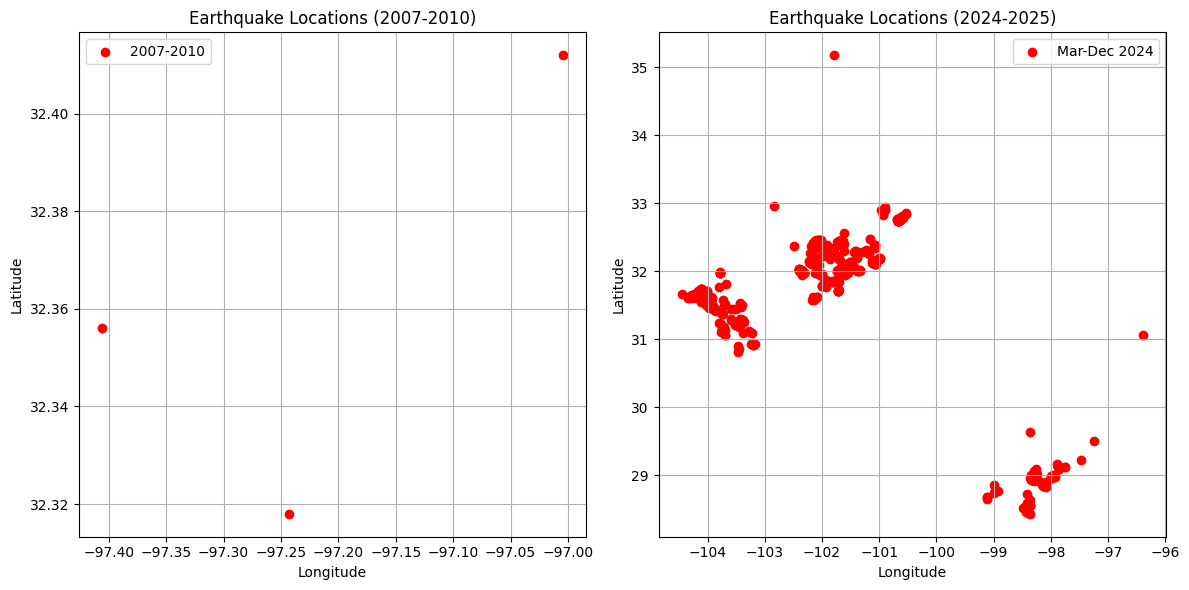

In [3]:
import datetime, json, requests
from pprint import pprint
import matplotlib.pyplot as plt
import pyproj

param1 = { "format": "geojson", "starttime": "2007-01-01","limit": 20000, "endtime": "2010-01-01", "minmagnitude": 1}
param2 = { "format": "geojson", "starttime": "2024-03-01","limit": 20000, "endtime": "2024-12-01", "minmagnitude": 1}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

response1 = requests.get(url, params=param1)
response2 = requests.get(url, params=param2)
data1 = json.loads(response1.text)
data2 = json.loads(response2.text)

quake_data1 = []
quake_data2 = []

for feature in data1['features']:
  depth = feature['geometry']['coordinates'][2]
  if depth < 10 and "Texas" in feature['properties']['place']:
    time = datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)

    quake_data1.append({
      "Mag": feature['properties']['mag'],
      "Place": feature['properties']['place'],
      "Time": time,
      "Lat": feature['geometry']['coordinates'][1],
      "Long": feature['geometry']['coordinates'][0],
      "Depth": depth
    })

for feature in data2['features']:
  depth = feature['geometry']['coordinates'][2]
  if depth < 10 and "Texas" in feature['properties']['place']:
    time = datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)

    quake_data2.append({
      "Mag": feature['properties']['mag'],
      "Place": feature['properties']['place'],
      "Time": time,
      "Lat": feature['geometry']['coordinates'][1],
      "Long": feature['geometry']['coordinates'][0],
      "Depth": depth
    })

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter([eq['Long'] for eq in quake_data1], [eq['Lat'] for eq in quake_data1], color='red', label='2007-2010')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Earthquake Locations (2007-2010)')
ax1.grid(True)
ax1.legend()

ax2.scatter([eq['Long'] for eq in quake_data2], [eq['Lat'] for eq in quake_data2], color='Red', label='Mar-Dec 2024' )
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Earthquake Locations (2024-2025)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()  # Adjust spacing to avoid overlapping
plt.show()

In [4]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import pandas as pd
import pyproj

file_path = '/content/drive/MyDrive/Fracking.csv'
fracking_df = pd.read_csv(file_path)

#Converting coordinate systems to WGS84
source_crs = 'epsg:4269'  # NAD83
target_crs = 'epsg:4326'  # WGS84

pd.set_option('display.max_rows', None)

transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

fracking_df['Latitude_WGS84'], fracking_df['Longitude_WGS84'] = transformer.transform(fracking_df['Latitude'].values, fracking_df['Longitude'].values)

#convert jobstart date into datetime object
fracking_df['JobStartDate'] = pd.to_datetime(fracking_df['JobStartDate'])

#convert jobend date into datetime object
fracking_df['JobEndDate'] = pd.to_datetime(fracking_df['JobEndDate'])

display(fracking_df[['JobStartDate','JobEndDate']])


<ipython-input-14-544501d0f434>:18: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-14-544501d0f434>:21: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,JobStartDate,JobEndDate
0,2025-01-02 00:00:00,2025-01-18 00:00:00
1,2025-01-02 00:00:00,2025-01-18 00:00:00
2,2025-01-02 00:00:00,2025-01-18 00:00:00
3,2025-01-03 00:00:00,2025-01-15 00:00:00
4,2025-01-03 00:00:00,2025-01-15 00:00:00
5,2025-01-08 00:00:00,2025-01-20 00:00:00
6,2024-10-12 00:00:00,2024-10-19 00:00:00
7,2024-10-13 04:03:51,2024-10-20 19:16:53
8,2024-10-14 23:38:59,2024-10-30 05:57:23
9,2024-10-14 20:10:46,2024-10-29 07:33:30


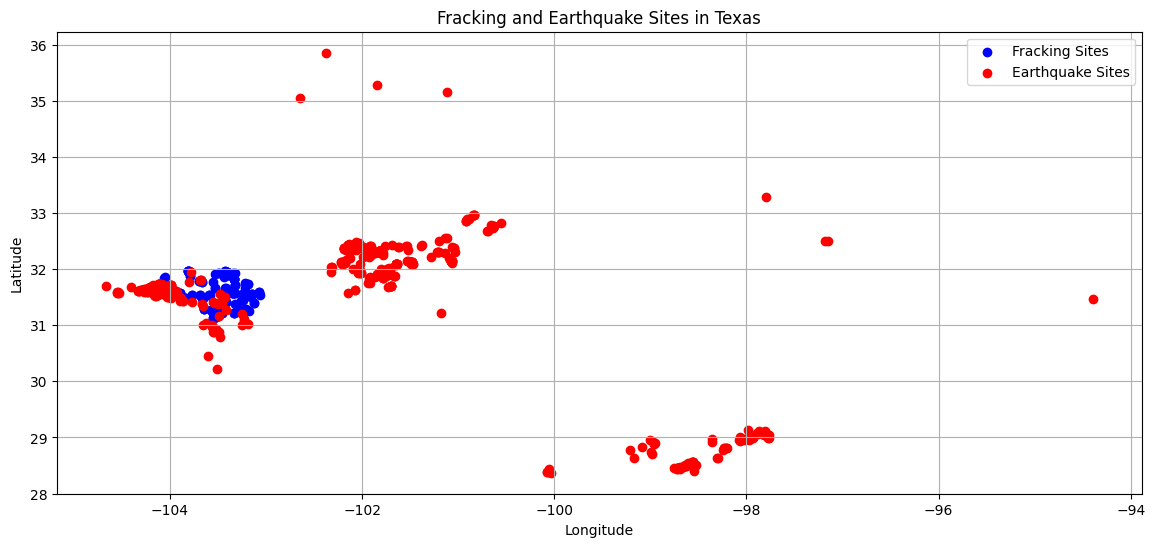

In [6]:
import matplotlib.pyplot as plt

frac_lats = fracking_df['Latitude_WGS84'].tolist()
frac_lons = fracking_df['Longitude_WGS84'].tolist()


eq_lats = [eq['Lat'] for eq in earthquake_data]
eq_lons = [eq['Long'] for eq in earthquake_data]

plt.figure(figsize=(14, 6))


plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')

plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking and Earthquake Sites in Texas')
plt.grid(True)
plt.legend()
plt.show()

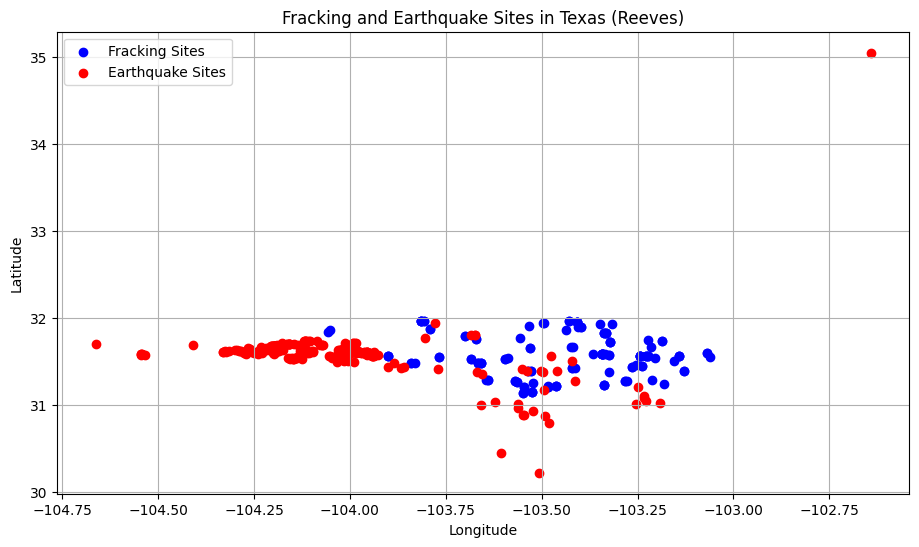

In [7]:
filtered_earthquake_data = [eq for eq in earthquake_data if eq['Long'] < -102.5]
import matplotlib.pyplot as plt

frac_lats = fracking_df['Latitude_WGS84'].tolist()
frac_lons = fracking_df['Longitude_WGS84'].tolist()

eq_lats = [eq['Lat'] for eq in filtered_earthquake_data]
eq_lons = [eq['Long'] for eq in filtered_earthquake_data]

plt.figure(figsize=(11, 6))
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking and Earthquake Sites in Texas (Reeves)')
plt.grid(True)
plt.legend()
plt.show()

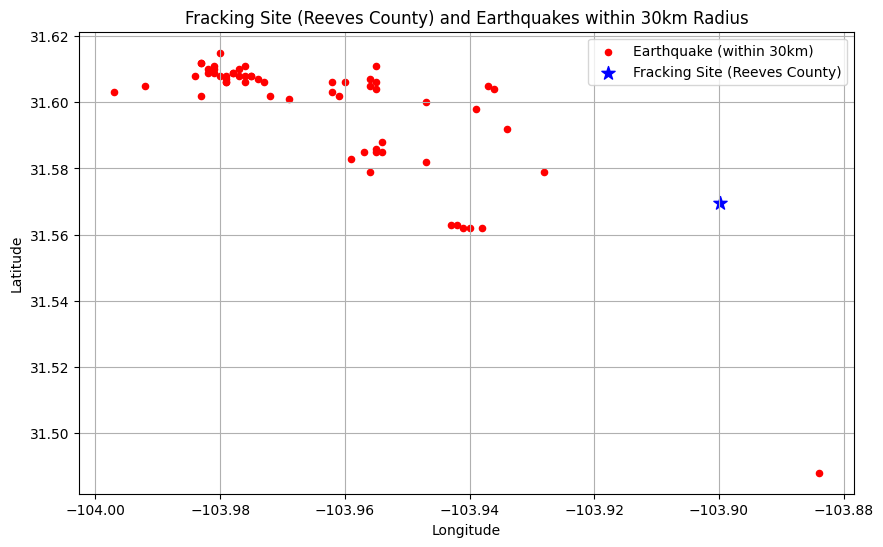

In [8]:
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Fracking site coordinates
frac_site = (31.569435, -103.89977)  # Reeves County

# Function to calculate distance
def distance(point1, point2):
    return geodesic(point1, point2).kilometers

# Create figure and axes
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot fracking site
ax.scatter(frac_site[1], frac_site[0], color='blue', marker='*', s=100, label='Fracking Site (Reeves County)')

# Plot earthquakes within 30km radius
for eq in earthquake_data:
    eq_coords = (eq['Lat'], eq['Long'])
    if distance(frac_site, eq_coords) <= 10:
        ax.scatter(eq['Long'], eq['Lat'], color='red', marker='o', s=20, label='Earthquake (within 30km)')

# Customize plot
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Fracking Site (Reeves County) and Earthquakes within 30km Radius')
ax.grid(True)

# Adjust legend to avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='best')

plt.show()

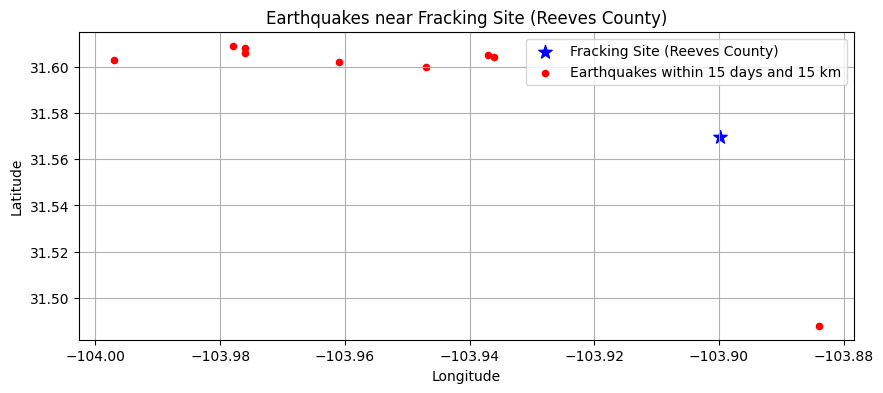

In [34]:
import pandas as pd
import datetime
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# ... (Load fracking data and earthquake data as before) ...

# Fracking site coordinates (Reeves County)
frac_site_reeves = (31.569435, -103.89977)

# Spatial and temporal correlation analysis (focused on Reeves County site)
radius_km = 10  # Set the radius for spatial proximity to 15 km
time_window_days = 10  # Set the time window for temporal proximity to 15 days

nearby_earthquakes = []
for eq in earthquake_data:
    eq_coords = (eq['Lat'], eq['Long'])
    distance = geodesic(frac_site_reeves, eq_coords).kilometers
    if distance <= radius_km:
        # Get fracking start date for Reeves County site (replace with your actual data)
        frac_start_date = fracking_df.loc[
    (fracking_df['Latitude_WGS84'] == frac_site_reeves[0]) & (fracking_df['Longitude_WGS84'] == frac_site_reeves[1]),
    'JobStartDate'
].iloc[0]  # Assuming only one matching fracking record
        eq_time = eq['Time']
        if frac_start_date - datetime.timedelta(days=time_window_days) <= eq_time <= frac_start_date + datetime.timedelta(
            days=time_window_days
        ):
            nearby_earthquakes.append(eq)


# Visualization: Plotting earthquakes near Reeves County fracking site
eq_lats = [eq['Lat'] for eq in nearby_earthquakes]
eq_lons = [eq['Long'] for eq in nearby_earthquakes]

plt.figure(figsize=(10, 4))
plt.scatter(frac_site_reeves[1], frac_site_reeves[0], color='blue', marker='*', s=100, label='Fracking Site (Reeves County)')
plt.scatter(eq_lons, eq_lats, color='red', marker='o', s=20, label='Earthquakes within 15 days and 15 km')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquakes near Fracking Site (Reeves County)')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
import networkx as nx
import plotly.graph_objects as go
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Assuming you have 'fracking_df' and 'earthquake_data' loaded

# Choose a specific fracking site (e.g., the first one)
frac_site_data = fracking_df.iloc[49]
frac_site_surface_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], frac_site_data['TVD(Km)'])

# Create a graph
graph = nx.Graph()

# Add the fracking site (surface) as a node
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)

# Add the fracking depth as a node
graph.add_node("Fracking Depth", pos=frac_site_depth_coords)

# Connect the fracking site (surface) to the fracking depth
graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

# Add earthquake site nodes (without connecting them to the fracking site)
for eq in earthquake_data:
    eq_coords = (eq['Lat'], eq['Long'], 0)  # Earthquake surface coordinates (z=0)
    graph.add_node(f"Earthquake Site {eq['Place']}", pos=eq_coords)

# Get node positions and invert z-coordinates
pos = nx.get_node_attributes(graph, 'pos')
for node, coords in pos.items():
    pos[node] = (coords[0], coords[1], -coords[2])

# Get earthquake magnitudes and create color scale
eq_magnitudes = [eq['Mag'] for eq in earthquake_data if f"Earthquake Site {eq['Place']}" in graph.nodes()]
color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))

# Create Plotly traces for nodes and edges
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in graph.nodes()],
    y=[pos[node][1] for node in graph.nodes()],
    z=[pos[node][2] for node in graph.nodes()],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_scale(i) if 'Earthquake Site' in node else 'blue' for i, node in enumerate(graph.nodes())],
        colorscale='Viridis',
        colorbar=dict(title='Magnitude')
    ),
    text=list(graph.nodes()),
    hoverinfo='text'
)

edge_trace = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
)

for edge in graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['z'] += tuple([z0, z1, None])

# Create the Plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site, Depth, and Nearby Earthquake (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)",
                        xaxis=dict(  # X-axis background color
                            backgroundcolor="rgb(200, 200, 230)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        ),
                        yaxis=dict(  # Y-axis background color
                            backgroundcolor="rgb(230, 200, 230)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        ),
                        zaxis=dict(  # Z-axis background color
                            backgroundcolor="rgb(230, 230, 200)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        )
                        # aspectratio=dict(x=1, y=1, z=0.7),
                        # camera=dict(
                        #     eye=dict(x=1.4, y=1.4, z=1.25)
                        # )
                    ),
                    showlegend=True,
                )
                )


fig.show()

<ipython-input-9-27ab50a2d41d>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))


In [10]:
import networkx as nx
import plotly.graph_objects as go
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Assuming you have 'fracking_df' and 'earthquake_data' loaded

# Choose a specific fracking site (e.g., the first one)
frac_site_data = fracking_df.iloc[49]  # Using the first fracking site
frac_site_surface_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], frac_site_data['TVD(Km)'])

# Create a graph
graph = nx.Graph()

# Add the fracking site (surface) as a node
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)

# Add the fracking depth as a node
graph.add_node("Fracking Depth", pos=frac_site_depth_coords)

# Connect the fracking site (surface) to the fracking depth
graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

# Add earthquake site nodes and connect if within 30km radius
radius = 20  # 30 km radius
for eq in earthquake_data:
    eq_coords = (eq['Lat'], eq['Long'], 0)  # Earthquake surface coordinates (z=0)
    distance_to_frac_site = geodesic(frac_site_surface_coords[:2], eq_coords[:2]).kilometers  # Calculate horizontal distance

    if distance_to_frac_site <= radius:
        graph.add_node(f"Earthquake Site {eq['Place']}", pos=eq_coords)
        graph.add_edge("Fracking Site (Surface)", f"Earthquake Site {eq['Place']}")  # Connect if within radius

# Get node positions and invert z-coordinates
pos = nx.get_node_attributes(graph, 'pos')
for node, coords in pos.items():
    pos[node] = (coords[0], coords[1], -coords[2])

# Get earthquake magnitudes and create color scale
eq_magnitudes = [eq['Mag'] for eq in earthquake_data if f"Earthquake Site {eq['Place']}" in graph.nodes()]
color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))

# Create Plotly traces for nodes and edges
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in graph.nodes()],
    y=[pos[node][1] for node in graph.nodes()],
    z=[pos[node][2] for node in graph.nodes()],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_scale(i) if 'Earthquake Site' in node else 'blue' for i, node in enumerate(graph.nodes())],
        colorscale='Viridis',
        colorbar=dict(title='Magnitude')
    ),
    text=list(graph.nodes()),
    hoverinfo='text'
)

edge_trace = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
)

for edge in graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['z'] += tuple([z0, z1, None])

# Create the Plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site, Depth, and Nearby Earthquake (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)",
                    ),
                    showlegend=True,
                )
                )

fig.show()


<ipython-input-10-7e916c425440>:42: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



<ipython-input-20-c133925e2f8f>:24: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-20-c133925e2f8f>:27: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



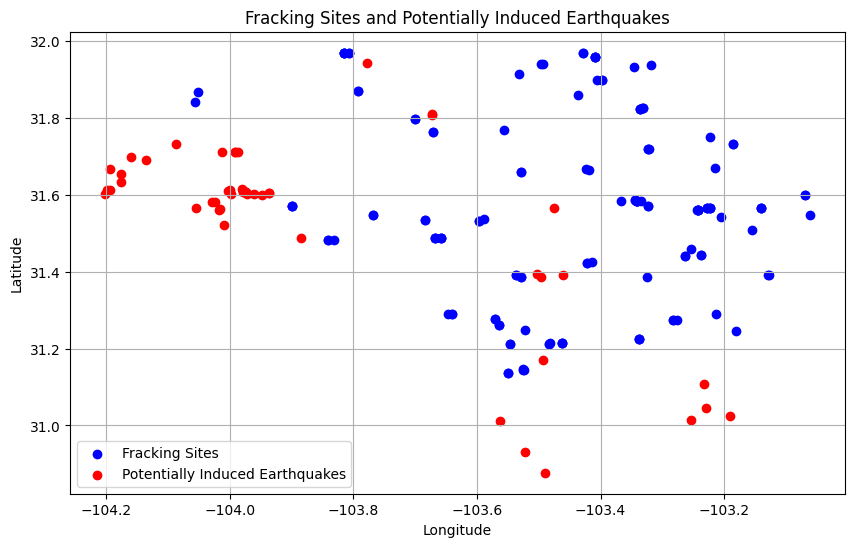

In [20]:
import pandas as pd
import datetime
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import pyproj #Import the pyproj module for coordinate transformations

# Load fracking data (replace with your actual file path)
file_path = '/content/drive/MyDrive/Fracking.csv'
fracking_df = pd.read_csv(file_path)

# Assuming 'earthquake_data' is already loaded (from previous code)

#Converting coordinate systems to WGS84
source_crs = 'epsg:4269'  # NAD83
target_crs = 'epsg:4326'  # WGS84

pd.set_option('display.max_rows', None)

transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

fracking_df['Latitude_WGS84'], fracking_df['Longitude_WGS84'] = transformer.transform(fracking_df['Latitude'].values, fracking_df['Longitude'].values)

#convert jobstart date into datetime object
fracking_df['JobStartDate'] = pd.to_datetime(fracking_df['JobStartDate'])

#convert jobend date into datetime object
fracking_df['JobEndDate'] = pd.to_datetime(fracking_df['JobEndDate'])


# Spatial and temporal correlation analysis
radius_km = 30  # Set the radius for spatial proximity
time_window_days = 1  # Set the time window for temporal proximity

potentially_induced_earthquakes = []
for eq in earthquake_data:
    for index, frac_site in fracking_df.iterrows():
        # Spatial check: Calculate distance and filter
        frac_coords = (frac_site['Latitude_WGS84'], frac_site['Longitude_WGS84'])
        eq_coords = (eq['Lat'], eq['Long'])
        distance = geodesic(frac_coords, eq_coords).kilometers
        if distance <= radius_km:
            # Temporal check: Check if within time window
            frac_start_date = frac_site['JobStartDate']
            frac_end_date = frac_site['JobEndDate']
            eq_time = eq['Time']
            if frac_start_date - datetime.timedelta(days=time_window_days) <= eq_time <= frac_end_date + datetime.timedelta(days=time_window_days):
                potentially_induced_earthquakes.append(eq)
                break  # Move to the next earthquake if found near a site within the time window

# Visualization: Plotting potentially induced earthquakes
frac_lats = fracking_df['Latitude_WGS84'].tolist()
frac_lons = fracking_df['Longitude_WGS84'].tolist()

induced_eq_lats = [eq['Lat'] for eq in potentially_induced_earthquakes]
induced_eq_lons = [eq['Long'] for eq in potentially_induced_earthquakes]

plt.figure(figsize=(10, 6))
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.scatter(induced_eq_lons, induced_eq_lats, color='red', label='Potentially Induced Earthquakes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking Sites and Potentially Induced Earthquakes')
plt.grid(True)
plt.legend()
plt.show()

<ipython-input-25-3267f253633a>:22: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-25-3267f253633a>:25: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



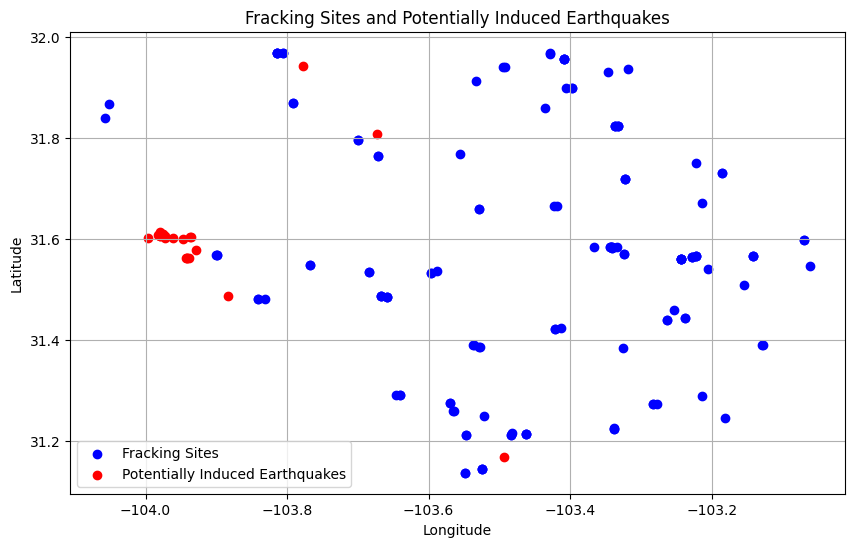

In [25]:
import pandas as pd
import datetime
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Load fracking data (replace with your actual file path)
file_path = '/content/drive/MyDrive/Fracking.csv'
fracking_df = pd.read_csv(file_path)

# Assuming 'earthquake_data' is already loaded (from previous code)
#Converting coordinate systems to WGS84
source_crs = 'epsg:4269'  # NAD83
target_crs = 'epsg:4326'  # WGS84

pd.set_option('display.max_rows', None)

transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

fracking_df['Latitude_WGS84'], fracking_df['Longitude_WGS84'] = transformer.transform(fracking_df['Latitude'].values, fracking_df['Longitude'].values)

#convert jobstart date into datetime object
fracking_df['JobStartDate'] = pd.to_datetime(fracking_df['JobStartDate'])

#convert jobend date into datetime object
fracking_df['JobEndDate'] = pd.to_datetime(fracking_df['JobEndDate'])


# Convert relevant columns to datetime objects
fracking_df['JobStartDate'] = pd.to_datetime(fracking_df['JobStartDate'])
fracking_df['JobEndDate'] = pd.to_datetime(fracking_df['JobEndDate'])

# Spatial and temporal correlation analysis
radius_km = 10  # Set the radius for spatial proximity
time_window_days = 10  # Set the time window for temporal proximity

potentially_induced_earthquakes = []
for eq in earthquake_data:
    for index, frac_site in fracking_df.iterrows():
        # Spatial check: Calculate distance and filter
        frac_coords = (frac_site['Latitude_WGS84'], frac_site['Longitude_WGS84'])
        eq_coords = (eq['Lat'], eq['Long'])
        distance = geodesic(frac_coords, eq_coords).kilometers
        if distance <= radius_km:
            # Temporal check: Check if within time window
            frac_start_date = frac_site['JobStartDate']
            frac_end_date = frac_site['JobEndDate']
            eq_time = eq['Time']  # Assuming 'Time' in earthquake_data is a datetime object
            if frac_start_date - datetime.timedelta(days=time_window_days) <= eq_time <= frac_end_date + datetime.timedelta(days=time_window_days):
                potentially_induced_earthquakes.append(eq)
                break  # Move to the next earthquake if found near a site within the time window

# Visualization: Plotting potentially induced earthquakes
frac_lats = fracking_df['Latitude_WGS84'].tolist()
frac_lons = fracking_df['Longitude_WGS84'].tolist()

induced_eq_lats = [eq['Lat'] for eq in potentially_induced_earthquakes]
induced_eq_lons = [eq['Long'] for eq in potentially_induced_earthquakes]

plt.figure(figsize=(10, 6))
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.scatter(induced_eq_lons, induced_eq_lats, color='red', label='Potentially Induced Earthquakes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking Sites and Potentially Induced Earthquakes')
plt.grid(True)
plt.legend()
plt.show()